In [55]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb, to_rgb
import pandas as pd
import seaborn as sns
import scipy
from teeplot import teeplot as tp

import random


In [56]:
# adapted from https://stackoverflow.com/a/78998203/17332200
def darken(color, amount):
    hue, saturation, value = rgb_to_hsv(to_rgb(color))
    return hsv_to_rgb((hue, saturation, value * amount))


In [57]:
def darken_palette(palette: str, amount: float) -> list:
    palette = sns.color_palette(palette)
    return [darken(color, amount) for color in palette]


In [58]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)


## Get Data


In [59]:
df = pd.read_parquet("https://osf.io/gk2ty/download")


In [60]:
df.columns


Index(['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index',
       'Run ID', 'Is Task Coding Site', 'Is Viability Site',
       'Is Task Coding Site Cumulative Count',
       'Is Viability Site Cumulative Count',
       'Prev Is Task Coding Site Cumulative Count',
       'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site',
       'Prev Is Viability Site', 'Site', 'Has Task', 'has task',
       'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP',
       'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK',
       'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS',
       'Is Task Coding Site Delta', 'Is Viability Site Delta',
       'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count',
       'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK',
       'Generation Born', 'Update Born'],
      dtype='object')

## Prep Data


In [61]:
df["Components"] = df["Task"].map(
    {
        "AND": 2,
        "ANDNOT": 3,
        "NAND": 1,
        "NOR": 4,
        "NOT": 1,
        "OR": 3,
        "ORNOT": 2,
        "XOR": 4,
        "EQUALS": 5,
    },
)


In [62]:
df["codes for num tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Is Task Coding Site"].transform("sum")


In [63]:
df["prev codes for num tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Prev Is Task Coding Site"].transform("sum")


In [64]:
df["prev codes for tasks"] = df["prev codes for num tasks"].astype(bool)


In [65]:
df["prev coded for tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Prev Is Task Coding Site Cumulative Count"].transform("sum")
df["prev coded for tasks"] = df["prev coded for tasks"].astype(bool)


In [66]:
df['First Task Generation'] = df['Generation Born'].where(
    df['has task'] != 0,
).groupby(
    [df['Treatment'], df['Run ID'], df['Task']],
    observed=True,
).transform('min')


In [67]:
df["SLIP_INSERTION_BOOL_MASK any"] = df.groupby(
    ["Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["SLIP_INSERTION_BOOL_MASK"].transform("any")


In [68]:
dff = df[
    (df["delta has task"] == 1)
    & (df["Generation Born"] == df["First Task Generation"])
    & (df["Treatment"] == "Slip-duplicate")
    & (~df["prev coded for tasks"])
    # & df["Is Task Coding Site"]
].reset_index(drop=True)
dff


,Task,Treatment,Genome Length,Lineage Generation Index,Run ID,Is Task Coding Site,Is Viability Site,Is Task Coding Site Cumulative Count,Is Viability Site Cumulative Count,Prev Is Task Coding Site Cumulative Count,...,SLIP_INSERTION_BOOL_MASK,Generation Born,Update Born,Components,codes for num tasks,prev codes for num tasks,prev codes for tasks,prev coded for tasks,First Task Generation,SLIP_INSERTION_BOOL_MASK any
0,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
1,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
2,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
3,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
4,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68114,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
68115,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
68116,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
68117,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False


In [69]:
dff.columns


Index(['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index',
       'Run ID', 'Is Task Coding Site', 'Is Viability Site',
       'Is Task Coding Site Cumulative Count',
       'Is Viability Site Cumulative Count',
       'Prev Is Task Coding Site Cumulative Count',
       'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site',
       'Prev Is Viability Site', 'Site', 'Has Task', 'has task',
       'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP',
       'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK',
       'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS',
       'Is Task Coding Site Delta', 'Is Viability Site Delta',
       'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count',
       'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK',
       'Generation Born', 'Update Born', 'Components', 'codes for num tasks',
       'prev codes for num tasks', 'prev codes for tasks',
       'prev coded for tasks', 

In [70]:
dfy = dff.groupby(
    ["Treatment", "Run ID", "Task"],
    observed=True,
)["Is Task Coding Site"].transform("mean")
print(dfy)

dff["Mean Is Task Coding Site"] = dfy


0        0.033613
1        0.033613
2        0.033613
3        0.033613
4        0.033613
           ...   
68114    0.000000
68115    0.000000
68116    0.000000
68117    0.000000
68118    0.000000
Name: Is Task Coding Site, Length: 68119, dtype: float64


In [71]:
dfp = dff.astype(
    {"Prev Slip Insertion Cumulative Count": bool},
).groupby(
    ["Treatment", "Run ID", "Task", "Prev Slip Insertion Cumulative Count"],
    observed=True,
).agg(
    {
        "Mean Is Task Coding Site": "first",
        "Is Task Coding Site": "mean",
        "Components": "first",
        "SLIP_INSERTION_BOOL_MASK any": "first",
    },
)

dfp["Is Task Coding Site"] /= dfp["Mean Is Task Coding Site"]
dfp = dfp.reset_index()
dfp


,Treatment,Run ID,Task,Prev Slip Insertion Cumulative Count,Mean Is Task Coding Site,Is Task Coding Site,Components,SLIP_INSERTION_BOOL_MASK any
0,Slip-duplicate,run_1590,AND,False,0.033613,2.063584,2,True
1,Slip-duplicate,run_1590,AND,True,0.033613,0.000000,2,True
2,Slip-duplicate,run_1590,ANDNOT,False,0.020661,0.000000,3,False
3,Slip-duplicate,run_1590,ANDNOT,True,0.020661,2.200000,3,False
4,Slip-duplicate,run_1590,EQUALS,False,0.028871,1.154545,5,False
...,...,...,...,...,...,...,...,...
482,Slip-duplicate,run_1619,OR,True,0.000000,NaN,3,False
483,Slip-duplicate,run_1619,ORNOT,False,0.007246,0.000000,2,False
484,Slip-duplicate,run_1619,ORNOT,True,0.007246,2.190476,2,False
485,Slip-duplicate,run_1619,XOR,False,0.000000,NaN,4,False


## base


In [72]:
dfp_ = dfp.copy()
dfp_["Prev Slip Insertion Cumulative Count"] = dfp_[
    "Prev Slip Insertion Cumulative Count"
].map(
    {True: "Slip Inserted", False: "Not Slip Inserted"}
)
dfp_


,Treatment,Run ID,Task,Prev Slip Insertion Cumulative Count,Mean Is Task Coding Site,Is Task Coding Site,Components,SLIP_INSERTION_BOOL_MASK any
0,Slip-duplicate,run_1590,AND,Not Slip Inserted,0.033613,2.063584,2,True
1,Slip-duplicate,run_1590,AND,Slip Inserted,0.033613,0.000000,2,True
2,Slip-duplicate,run_1590,ANDNOT,Not Slip Inserted,0.020661,0.000000,3,False
3,Slip-duplicate,run_1590,ANDNOT,Slip Inserted,0.020661,2.200000,3,False
4,Slip-duplicate,run_1590,EQUALS,Not Slip Inserted,0.028871,1.154545,5,False
...,...,...,...,...,...,...,...,...
482,Slip-duplicate,run_1619,OR,Slip Inserted,0.000000,NaN,3,False
483,Slip-duplicate,run_1619,ORNOT,Not Slip Inserted,0.007246,0.000000,2,False
484,Slip-duplicate,run_1619,ORNOT,Slip Inserted,0.007246,2.190476,2,False
485,Slip-duplicate,run_1619,XOR,Not Slip Inserted,0.000000,NaN,4,False


In [73]:
data = dfp_[
    (dfp_["Prev Slip Insertion Cumulative Count"] == "Slip Inserted")
].groupby(
    ["Prev Slip Insertion Cumulative Count", "Run ID", "Is Task Coding Site", "Components", "Task"],
    observed=True,
).median(numeric_only=True).reset_index()
print(len(data))
data


159


,Prev Slip Insertion Cumulative Count,Run ID,Is Task Coding Site,Components,Task,Mean Is Task Coding Site,SLIP_INSERTION_BOOL_MASK any
0,Slip Inserted,run_1590,0.000000,1,NOT,0.018405,1.0
1,Slip Inserted,run_1590,0.000000,2,AND,0.033613,1.0
2,Slip Inserted,run_1590,0.556306,4,NOR,0.016194,0.0
3,Slip Inserted,run_1590,0.952202,5,EQUALS,0.028871,0.0
4,Slip Inserted,run_1590,2.200000,3,ANDNOT,0.020661,0.0
...,...,...,...,...,...,...,...
154,Slip Inserted,run_1619,0.918310,1,NOT,0.061350,0.0
155,Slip Inserted,run_1619,1.143590,2,AND,0.022422,0.0
156,Slip Inserted,run_1619,1.434211,3,ANDNOT,0.013761,0.0
157,Slip Inserted,run_1619,1.441026,5,EQUALS,0.014235,0.0


In [74]:
# Perform one-sample Wilcoxon signed-rank test for each "Components" group
# against the null hypothesis median = 1.0
wilcoxon_results = data.groupby("Components").apply(
    lambda x: scipy.stats.wilcoxon(
        x["Is Task Coding Site"] - 1.0,  # shift by 1.0
        alternative='greater',
    )
)

# Create a DataFrame to store the test results
wilcoxon_df = pd.DataFrame(
    wilcoxon_results.tolist(),
    index=wilcoxon_results.index,
    columns=["W-statistic", "p-value"]
)

display(wilcoxon_df)

group_stats = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()
display(group_stats)

group_sizes = data.groupby(["Components", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')
display(group_sizes)


/tmp/ipykernel_343182/1046056488.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wilcoxon_results = data.groupby("Components").apply(


,W-statistic,p-value
Components,,
1,305.0,0.887359
2,484.0,0.002771
3,511.0,0.000659
4,432.0,0.010715
5,103.0,0.035139


,Components,Prev Slip Insertion Cumulative Count,mean,std
0,1,Slip Inserted,0.884347,1.289272
1,2,Slip Inserted,1.644688,1.256065
2,3,Slip Inserted,1.688784,1.040792
3,4,Slip Inserted,1.308848,0.755445
4,5,Slip Inserted,1.343241,0.674396


,Components,Prev Slip Insertion Cumulative Count,size
0,1,Slip Inserted,39
1,2,Slip Inserted,35
2,3,Slip Inserted,35
3,4,Slip Inserted,34
4,5,Slip Inserted,16


/tmp/ipykernel_343182/2868494086.py:15: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_343182/2868494086.py:30: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.stripplot(


teeplots/density-norm=width+hue=components+viz=violinplot+x=components+y=is-task-coding-site+ext=.pdf
teeplots/density-norm=width+hue=components+viz=violinplot+x=components+y=is-task-coding-site+ext=.png


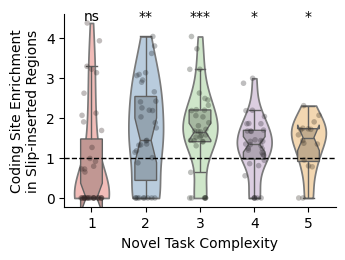

In [ ]:
with tp.teed(
    sns.violinplot,
    data=data,
    y="Is Task Coding Site",
    x="Components",
    hue="Components",
    density_norm="width",
    cut=0,
    gap=0.2,
    inner=None,
    legend=False,
    palette="Pastel1",
    teeplot_outexclude="palette",
    teeplot_outattrs={"prevcoding": False},
) as ax:
    sns.boxplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        gap=0.2,
        notch=True,
        palette=darken_palette("Pastel1", 0.8),
        color="black",
        width=0.5,
        linewidth=1,
        fliersize=0,
        ax=ax,
        legend=False,
    )
    sns.stripplot(
        data=data,
        y="Is Task Coding Site",
        x="Components",
        hue="Components",
        jitter=0.2,
        palette=darken_palette("Pastel1", 0.2),
        size=4,
        alpha=0.3,
        ax=ax,
        legend=False,
    )
    ax.axhline(1, color="black", linestyle="--", lw=1)
    ax.set_ylabel("Coding Site Enrichment\nin Slip-inserted Regions")
    ax.set_xlabel("Novel Task Complexity")
    ax.figure.set_size_inches(3.5, 2.5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add significance annotations based on wilcoxon_df
    y_max = ax.get_ylim()[1]
    x_positions = ax.get_xticks()

    # Loop over each component in sorted order
    for i, comp in enumerate(sorted(wilcoxon_df.index)):
        p_val = wilcoxon_df.loc[comp, 'p-value']
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        ax.text(x_positions[i], y_max * 0.95, sig, ha='center', va='bottom', fontsize=10, color='black')


In [76]:
# Perform one-sample Wilcoxon signed-rank test for each "Components" group
# against the null hypothesis median = 1.0
data["one"] = 1
wilcoxon_results = data.groupby("one").apply(
    lambda x: scipy.stats.wilcoxon(
        x["Is Task Coding Site"] - 1.0,  # shift by 1.0
        alternative='greater',
    )
)

# Create a DataFrame to store the test results
wilcoxon_df = pd.DataFrame(
    wilcoxon_results.tolist(),
    index=wilcoxon_results.index,
    columns=["W-statistic", "p-value"]
)

display(wilcoxon_df)

group_stats = data.groupby(["one", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()
display(group_stats)

group_sizes = data.groupby(["one", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')
display(group_sizes)


/tmp/ipykernel_343182/729644866.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wilcoxon_results = data.groupby("one").apply(


,W-statistic,p-value
one,,
1,8325.0,0.000352


,one,Prev Slip Insertion Cumulative Count,mean,std
0,1,Slip Inserted,1.365747,1.110433


,one,Prev Slip Insertion Cumulative Count,size
0,1,Slip Inserted,159


/home/mmore500/2025-08-01/AvidaGeneDupe/.env/lib64/python3.10/site-packages/teeplot/teeplot.py:225: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/tmp/ipykernel_343182/1014242842.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_343182/1014242842.py:13: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_343182/1014242842.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_343182/1014242

teeplots/density-norm=width+viz=violinplot+y=is-task-coding-site+ext=.pdf
teeplots/density-norm=width+viz=violinplot+y=is-task-coding-site+ext=.png


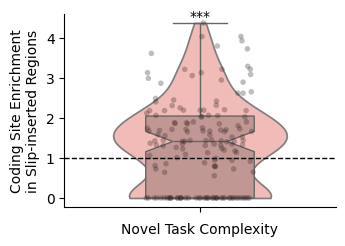

In [ ]:
with tp.teed(
    sns.violinplot,
    data=data,
    y="Is Task Coding Site",
    density_norm="width",
    cut=0,
    gap=0.2,
    inner=None,
    legend=False,
    palette="Pastel1",
    teeplot_outexclude="palette",
    teeplot_outattrs={"prevcoding": False},
) as ax:
    sns.boxplot(
        data=data,
        y="Is Task Coding Site",
        gap=0.2,
        notch=True,
        palette=darken_palette("Pastel1", 0.8),
        color="black",
        width=0.5,
        linewidth=1,
        fliersize=0,
        ax=ax,
        legend=False,
    )
    sns.stripplot(
        data=data,
        y="Is Task Coding Site",
        jitter=0.2,
        palette=darken_palette("Pastel1", 0.2),
        size=4,
        alpha=0.3,
        ax=ax,
        legend=False,
    )
    ax.axhline(1, color="black", linestyle="--", lw=1)
    ax.set_ylabel("Coding Site Enrichment\nin Slip-inserted Regions")
    ax.set_xlabel("Novel Task Complexity")
    ax.figure.set_size_inches(3.5, 2.5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add significance annotations based on wilcoxon_df
    y_max = ax.get_ylim()[1]
    x_positions = ax.get_xticks()

    # Loop over each component in sorted order
    for i, comp in enumerate(sorted(wilcoxon_df.index)):
        p_val = wilcoxon_df.loc[comp, 'p-value']
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        ax.text(x_positions[i], y_max * 0.95, sig, ha='center', va='bottom', fontsize=10, color='black')
